In [1]:
import numpy as np
import pickle
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModel, AutoConfig
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_2d_projection, plot_pca_component_variance
import torch.nn.functional as F

from functools import partial
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from modular_transformers.models import components

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
activation_path = "/om2/user/jackking/modular_transformers/scripts/dimensionality_reduction"
path = "/om2/user/jackking/modular_transformers/scripts/attention_interpretability"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_grad_enabled(False)



/om2/user/jackking/anaconda/envs/modular_transformers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "gpt2-xl"
datatype = "natural_language_ud"
sub_datatype = "natural"
model_type = "lm"
#num_labels, num_samples/num_labels, num_layers+1, context_len, embedding_dim
activations = pickle.load(open(f"{activation_path}/activations/{datatype}/{sub_datatype}/{model_type}/{model_name}.pkl", "rb"))
#num_samples, num_layers+1, context_len, embedding_dim
activations = activations.reshape(activations.shape[0] * activations.shape[1], activations.shape[2], activations.shape[3], activations.shape[4])

In [28]:
def run(activations, num_base_tokens=2, start_token=3):
    num_layers = activations.shape[1]
    num_tokens = activations.shape[2]
    num_samples = activations.shape[0]
    r2_matrix = np.zeros((num_layers, num_samples, num_tokens-start_token-num_base_tokens))
    for layer in range(num_layers):
        # print(f"Layer {layer}")
        for token in range(start_token+num_base_tokens, num_tokens):
            for sample in range(num_samples):
                base_tokens = activations[sample, layer, start_token:start_token+num_base_tokens, :]
                target_token = activations[sample, layer, token, :]
                w = np.linalg.lstsq(base_tokens.T, target_token, rcond=None)[0]
                prediction = np.dot(base_tokens.T, w)
                target_mean = np.mean(target_token, axis=0)
                total_sum_of_squares = np.sum((target_token - target_mean)**2)
                residual_sum_of_squares = np.sum((target_token - prediction)**2)
                r2 = 1 - residual_sum_of_squares / total_sum_of_squares
                r2_matrix[layer, sample, token-start_token-num_base_tokens] = r2
    return r2_matrix

In [18]:
def compute_model_sparsity(activations, threshold_multiplier=0.01):
    #num_samples, num_layers+1, context_len, embedding_dim
    num_samples = activations.shape[0]
    num_layers = activations.shape[1]
    context_len = activations.shape[2]
    sparsity = np.zeros((num_layers, num_samples))
    
    for layer in range(num_layers):

        threshold = threshold_multiplier * np.mean(np.abs(activations[:, layer, :, :]))

        for sample in range(num_samples):
            act = torch.abs(torch.tensor(activations[sample, layer, :, :]))
            sparsity[layer, sample] = torch.sigmoid(50 * (act - threshold)).sum() / context_len
            
    return sparsity

In [35]:
curvature = compute_model_curvature(torch.tensor(activations))
sparsity = compute_model_sparsity(activations, threshold_multiplier=0.01)

5815it [01:01, 94.00it/s]


In [44]:
r2_matrix.shape

(49, 5815, 5)

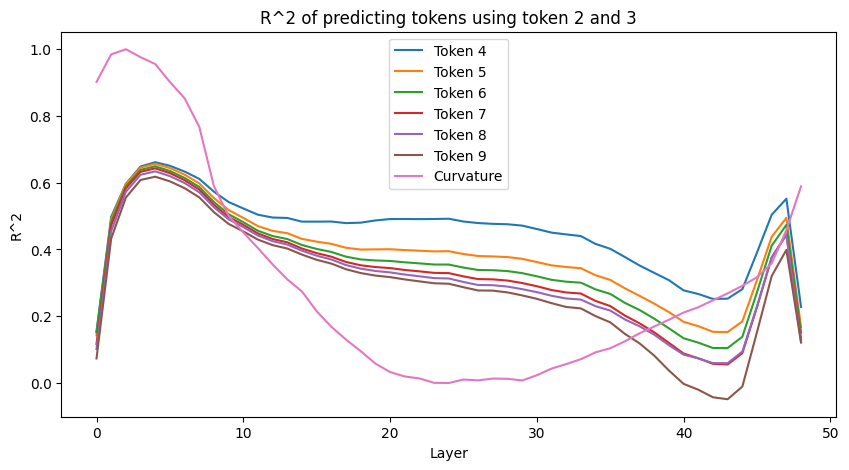

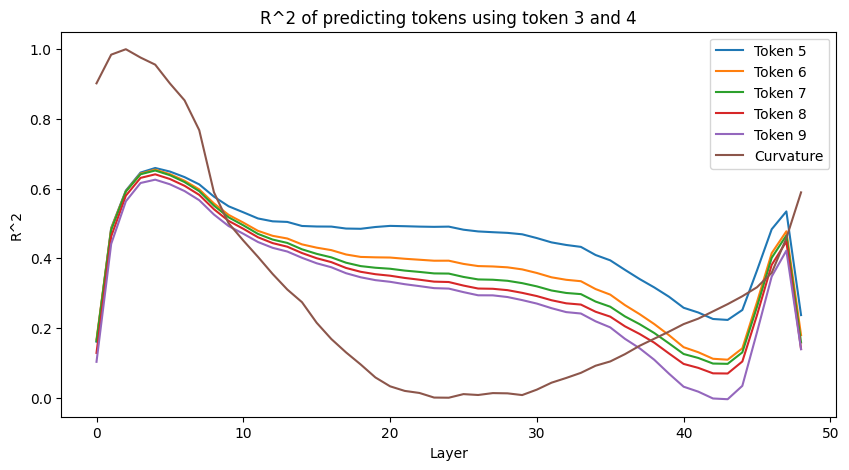

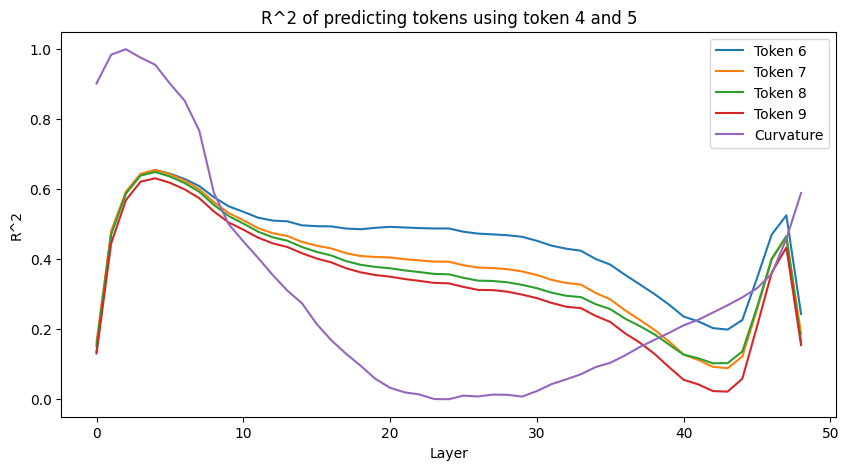

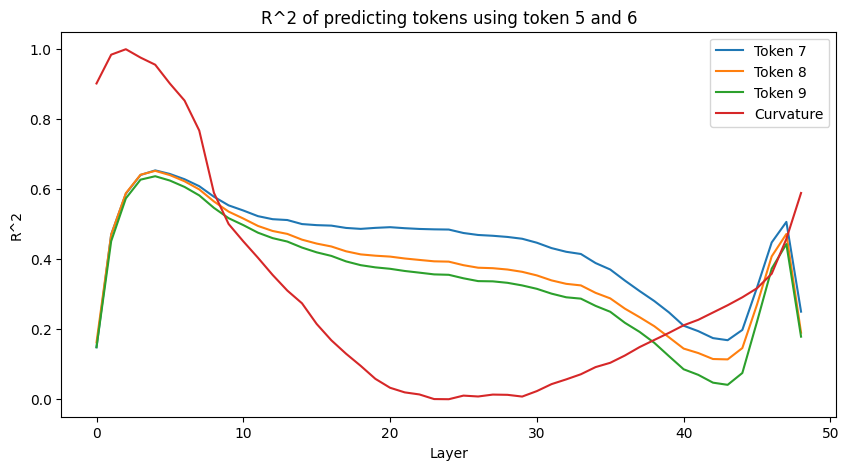

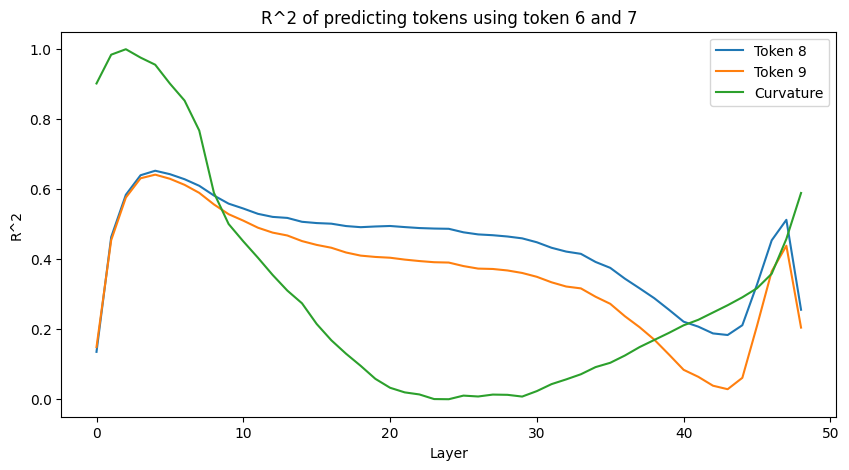

In [27]:
num_base_tokens = 2

for start_token in [2, 3, 4, 5, 6]:
    r2_matrix = run(activations, num_base_tokens=num_base_tokens, start_token=start_token)
    r2_matrix = np.mean(r2_matrix, axis=1)

    plt.figure(figsize=(10, 5))
    for token in range(r2_matrix.shape[1]):
        plt.plot(r2_matrix[:, token], label=f"Token {token + num_base_tokens + start_token}") 
    plt.xlabel("Layer")
    plt.ylabel("R^2")

    curve = np.mean(curvature["curve"], axis=1)
    normalized_curve = (curve - np.min(curve)) / (np.max(curve) - np.min(curve))
    plt.plot(normalized_curve, label="Curvature")

    plt.title(f"R^2 of predicting tokens using token {start_token} and {start_token+1}")

    plt.legend()
    plt.show()

we want correlation between predictive ability and curvature over layers for each sample
we also want correlation between curvature and the predictive ability at each token_idx for each sample and layer

we want to do this for both full curvature and only local curvature

In [36]:
np.array(curvature["all_layer_curve_all"]).shape

(5815, 49, 8)

In [86]:
correlation_matrix = np.zeros((r2_matrix.shape[2], start_token+num_base_tokens-1, 2))

for predicted_token_idx in range(r2_matrix.shape[2]):
    print(f"Predicted token {predicted_token_idx}")
    for num_curves in range(1, start_token+num_base_tokens-1):
        correlation_sum = 0
        pvalue_sum = 0
        for sample_idx in range(400):
            r2s = r2_matrix[:, sample_idx, predicted_token_idx]
            local_curvature = np.array(curvature["all_layer_curve_all"])[sample_idx, :, start_token-num_curves+num_base_tokens-2:start_token+num_base_tokens-2]
            local_curvature = np.mean(local_curvature, axis=1)
            r2s = r2s.flatten()
            curvature_over_layers = curvature_over_layers.flatten()
            correlation = pearsonr(r2s, local_curvature)
            correlation_sum += correlation[0]
            pvalue_sum += correlation[1]
        correlation_matrix[predicted_token_idx, num_curves-1][0] = correlation_sum / r2_matrix.shape[1]
        correlation_matrix[predicted_token_idx, num_curves-1][1] = pvalue_sum / r2_matrix.shape[1]


Predicted token 0
Predicted token 1
Predicted token 2
Predicted token 3
Predicted token 4


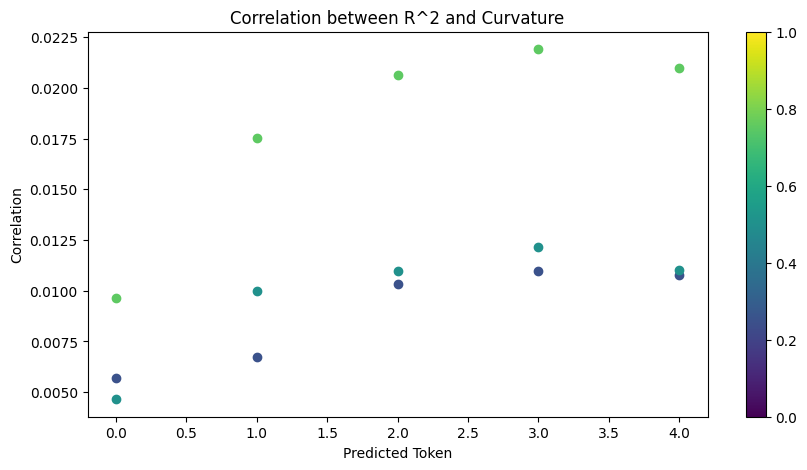

In [88]:
cmap = plt.get_cmap("viridis")
plt.figure(figsize=(10, 5))
for predicted_token_idx in range(r2_matrix.shape[2]):
    for num_curves in range(1, start_token+num_base_tokens-1):
        plt.scatter(predicted_token_idx, correlation_matrix[predicted_token_idx, num_curves-1][0], color=cmap(num_curves / (start_token+num_base_tokens-1)))
        if correlation_matrix[predicted_token_idx, num_curves-1][1] > 0.05:
            plt.scatter(predicted_token_idx, correlation_matrix[predicted_token_idx, num_curves-1][0], color="red")

plt.xlabel("Predicted Token")
plt.ylabel("Correlation")
plt.title("Correlation between R^2 and Curvature")
plt.colorbar()
plt.show()

In [62]:
r2_matrix.shape

(49, 5815, 4)

In [65]:
local_curvature[0, 0, ]

0.1003982331034724

In [82]:
start_token = 3
num_base_tokens = 2
# r2_matrix = run(activations, num_base_tokens=num_base_tokens, start_token=start_token)
correlation_matrix = np.zeros((r2_matrix.shape[0], r2_matrix.shape[2], start_token+num_base_tokens-1, 2))
for predicted_token_idx in range(r2_matrix.shape[2]):
    for num_curves in range(1, start_token+num_base_tokens-1):
        for layer in range(r2_matrix.shape[0]):
            r2s = r2_matrix[layer, :, predicted_token_idx]
            local_curvature = np.array(curvature["all_layer_curve_all"])[:, layer, start_token-num_curves+num_base_tokens-2:start_token+num_base_tokens-2]
            local_curvature = np.mean(local_curvature, axis=1)
            #correlate r2 and curvature
            r2s = r2s.flatten()
            local_curvature = local_curvature.flatten()
            r2s = r2s[~np.isnan(local_curvature)]
            if len(r2s) != 5815:
                print(predicted_token_idx, num_curves, layer)
            # local_curvature = local_curvature[~np.isnan(local_curvature)]
            correlation = pearsonr(r2s, local_curvature)
            correlation_matrix[layer, predicted_token_idx, num_curves-1][0] = correlation[0]
            correlation_matrix[layer, predicted_token_idx, num_curves-1][1] = correlation[1]

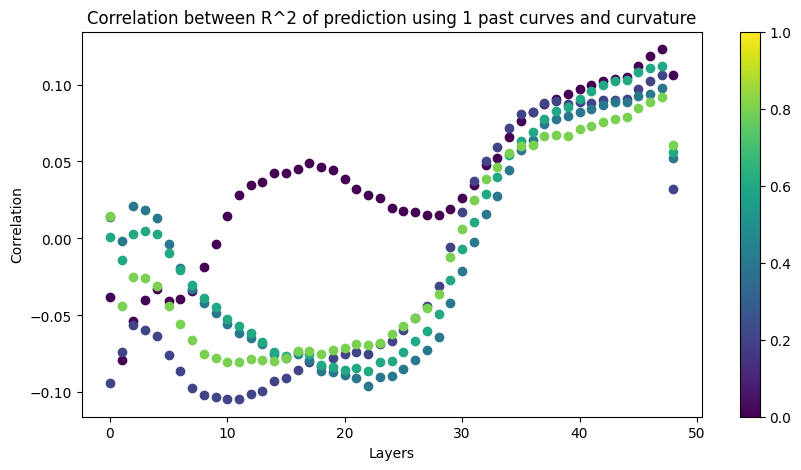

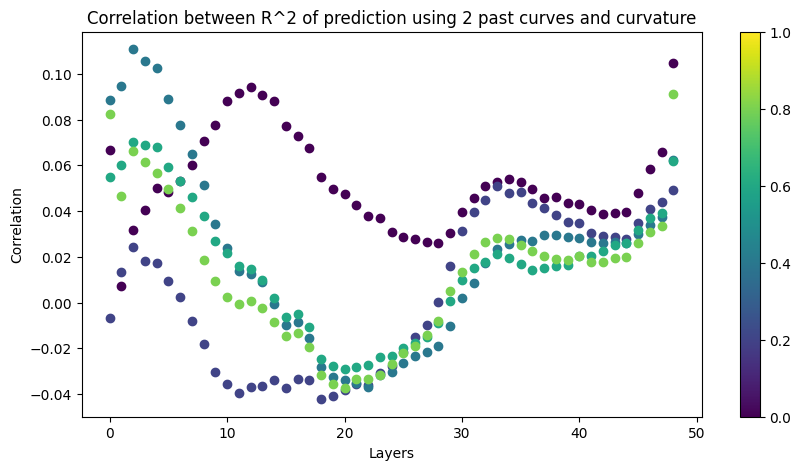

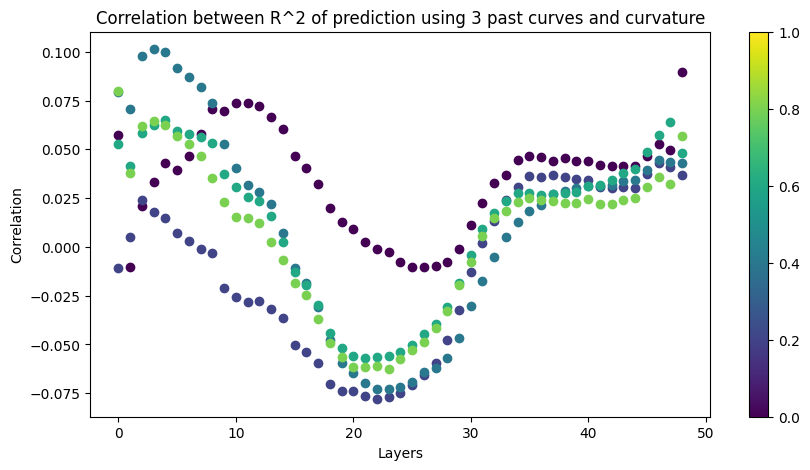

In [83]:
cmap = plt.get_cmap("viridis")
for num_curves in range(1, 4):
    plt.figure(figsize=(10, 5))
    for predicted_token_idx in range(r2_matrix.shape[2]):
        for layer in range(r2_matrix.shape[0]):
            plt.scatter(layer, correlation_matrix[layer, predicted_token_idx, num_curves-1][0], color=cmap(predicted_token_idx / r2_matrix.shape[2]))
            # if correlation_matrix[layer, predicted_token_idx, num_curves-1][1] > 0.05:
            #     plt.scatter(layer, correlation_matrix[layer, predicted_token_idx, num_curves-1][0], color="red")
            

    plt.colorbar()
    plt.xlabel("Layers")
    plt.ylabel("Correlation")
    plt.title(f"Correlation between R^2 of prediction using {num_curves} past curves and curvature")

    plt.show()

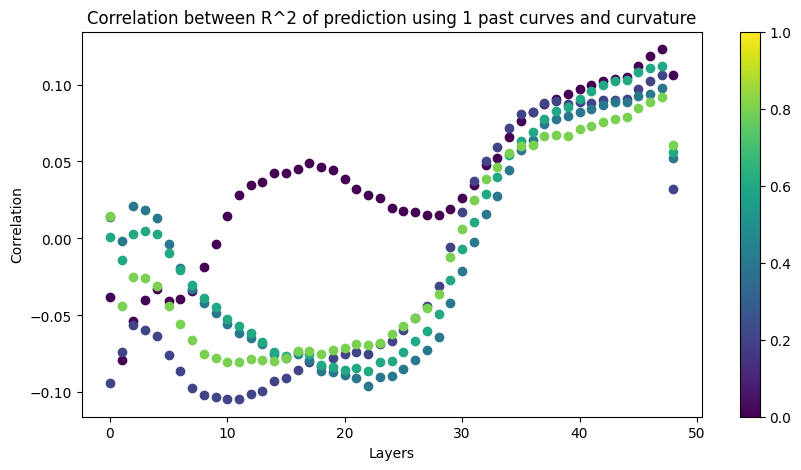

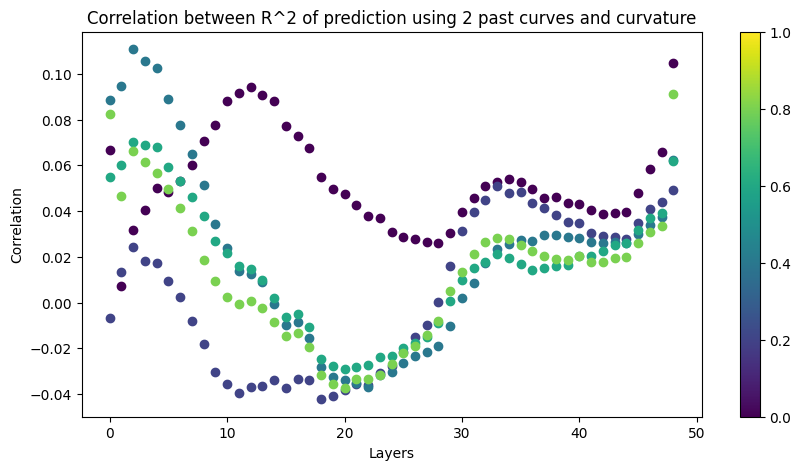

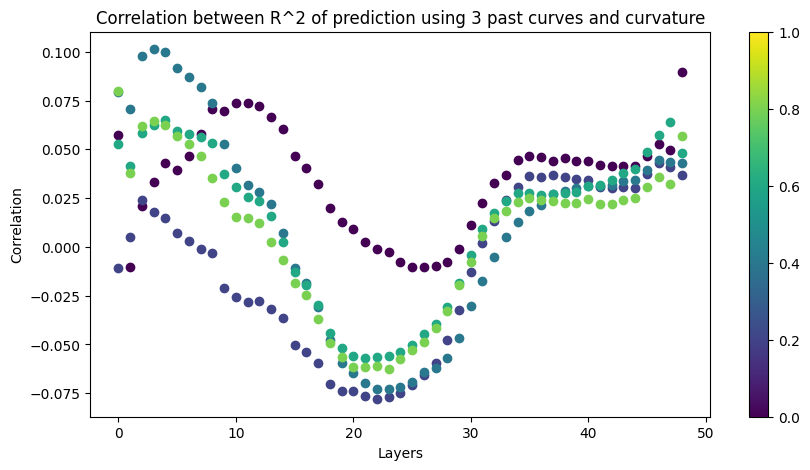

In [69]:
cmap = plt.get_cmap("viridis")
for num_curves in range(1, 4):
    plt.figure(figsize=(10, 5))
    for predicted_token_idx in range(r2_matrix.shape[2]):
        for layer in range(r2_matrix.shape[0]):
            plt.scatter(layer, correlation_matrix[layer, predicted_token_idx, num_curves-1], color=cmap(predicted_token_idx / r2_matrix.shape[2]))

    plt.colorbar()
    plt.xlabel("Layers")
    plt.ylabel("Correlation")
    plt.title(f"Correlation between R^2 of prediction using {num_curves} past curves and curvature")

    plt.show()

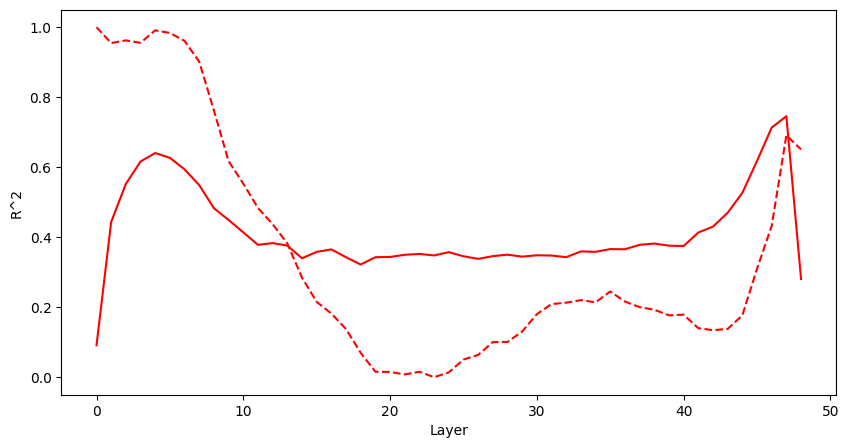

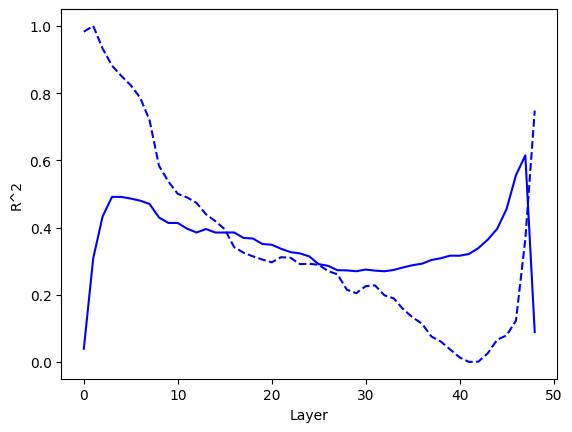

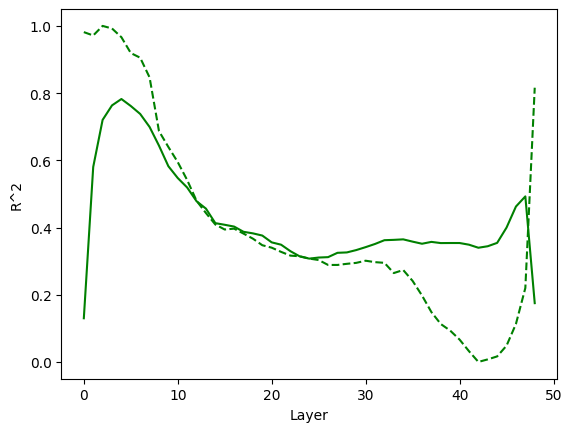

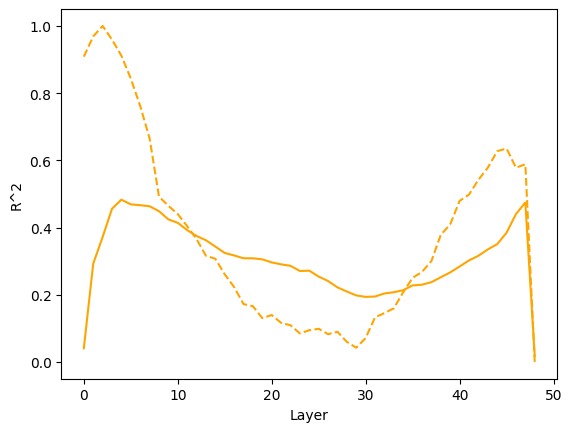

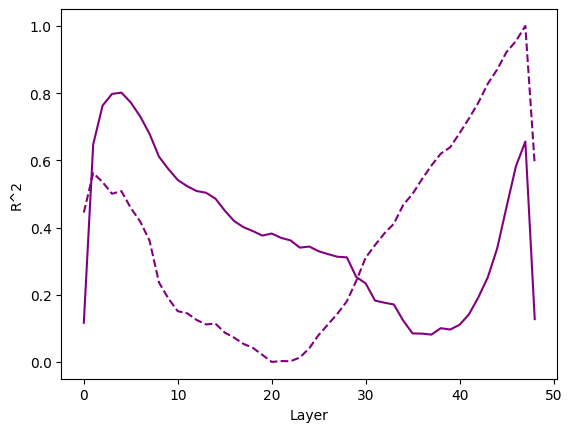

In [34]:
start_token = 3
num_base_tokens = 2
r2_matrix = run(activations, num_base_tokens=num_base_tokens, start_token=start_token)
color_dict = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "purple", 5: "brown", 6: "pink", 7: "gray", 8: "black", 9: "yellow"}
plt.figure(figsize=(10, 5))
for sample in range(5):
    plt.plot(r2_matrix[:, sample, 4], color=color_dict[sample]) 
    curve = curvature["curve"][:, sample]
    normalized_curve = (curve - np.min(curve)) / (np.max(curve) - np.min(curve))
    plt.plot(normalized_curve, color=color_dict[sample], linestyle="--")
    plt.xlabel("Layer")
    plt.ylabel("R^2")
    plt.show()

In [ ]:
num_base_tokens = 3

for start_token in [2, 3, 4, 5, 6]:
    r2_matrix = run(activations, num_base_tokens=num_base_tokens, start_token=start_token)
    r2_matrix = np.mean(r2_matrix, axis=1)

    plt.figure(figsize=(10, 5))
    for token in range(r2_matrix.shape[1]):
        plt.plot(r2_matrix[:, token], label=f"Token {token + num_base_tokens + start_token}") 
    plt.xlabel("Layer")
    plt.ylabel("R^2")

    curve = np.mean(curvature["curve"], axis=1)
    normalized_curve = (curve - np.min(curve)) / (np.max(curve) - np.min(curve))
    plt.plot(normalized_curve, label="Curvature")

    plt.title(f"R^2 of predicting tokens using token {start_token}, {start_token+1}, and {start_token+2}")

    plt.legend()
    plt.show()

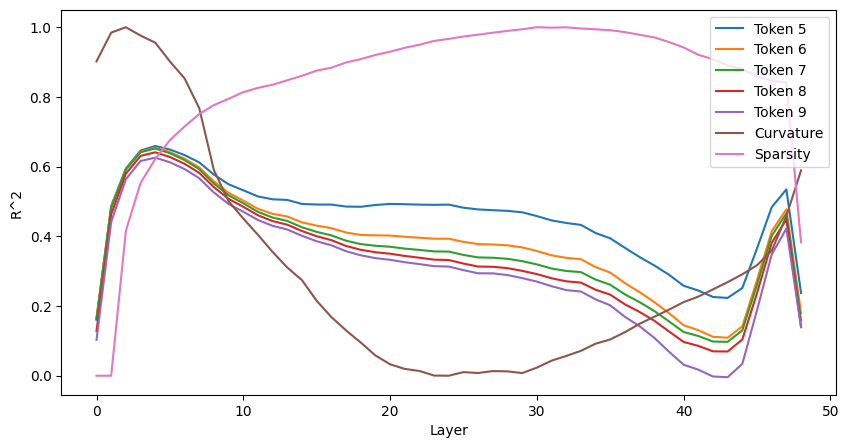

In [14]:
plt.figure(figsize=(10, 5))
for token in range(r2_matrix.shape[1]):
    plt.plot(r2_matrix[:, token], label=f"Token {token + num_base_tokens + start_token}") 
plt.xlabel("Layer")
plt.ylabel("R^2")

curve = np.mean(curvature["curve"], axis=1)
normalized_curve = (curve - np.min(curve)) / (np.max(curve) - np.min(curve))
plt.plot(normalized_curve, label="Curvature")

sparsity = np.mean(sparsity, axis=1)
cutoff_sparsity = sparsity.copy()
cutoff_sparsity[0] = sparsity[1]
normalized_sparsity = (cutoff_sparsity - np.min(cutoff_sparsity)) / (np.max(cutoff_sparsity) - np.min(cutoff_sparsity))
plt.plot(normalized_sparsity, label="Sparsity")

plt.legend()
plt.show()

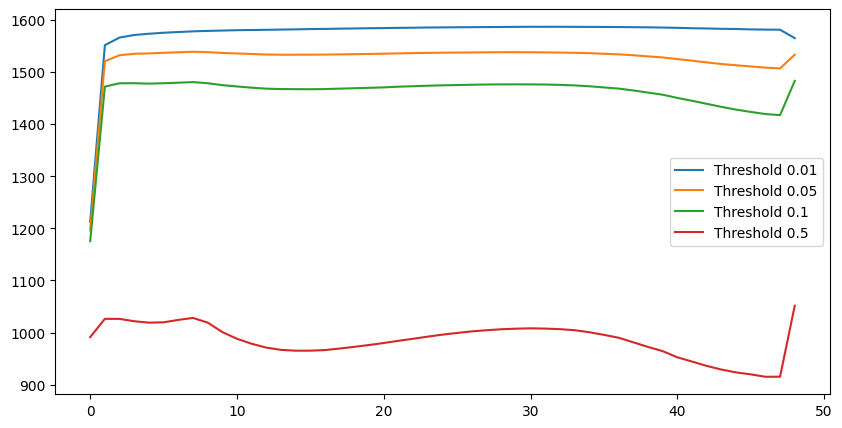

In [21]:
plt.figure(figsize=(10, 5))
for threshold in [0.01, 0.05, 0.1, 0.5]:
    sparsity = compute_model_sparsity(activations, threshold_multiplier=threshold)
    sparsity = np.mean(sparsity, axis=1)
    plt.plot(sparsity, label=f"Threshold {threshold}")
plt.legend()
plt.show()

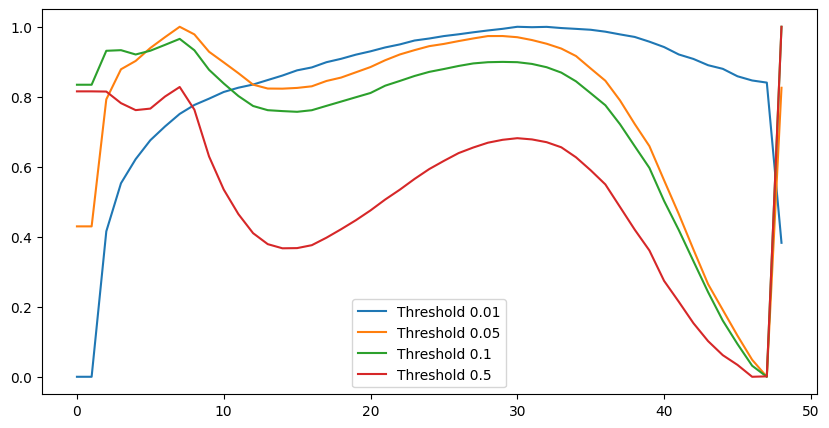

In [20]:
plt.figure(figsize=(10, 5))
for threshold in [0.01, 0.05, 0.1, 0.5]:
    sparsity = compute_model_sparsity(activations, threshold_multiplier=threshold)
    sparsity = np.mean(sparsity, axis=1)
    cutoff_sparsity = sparsity.copy()
    cutoff_sparsity[0] = sparsity[1]
    normalized_sparsity = (cutoff_sparsity - np.min(cutoff_sparsity)) / (np.max(cutoff_sparsity) - np.min(cutoff_sparsity))
    plt.plot(normalized_sparsity, label=f"Threshold {threshold}")
plt.legend()
plt.show()